<a href="https://colab.research.google.com/github/Adam-Rao/Cats-and-Dogs/blob/master/CatsAndDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!unzip "/content/drive/My Drive/dogs-vs-cats.zip" -d "/content/drive/My Drive/Cats VS Dogs Project"

In [ ]:
#!unzip "/content/drive/My Drive/Cats VS Dogs Project/test1.zip" -d "/content/drive/My Drive/Cats VS Dogs Project/test"

In [ ]:
#!unzip "/content/drive/My Drive/Cats VS Dogs Project/train.zip" -d "/content/drive/My Drive/Cats VS Dogs Project/train"

In [12]:
import datetime
import _io
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_hub as hub
from typing import List, Tuple
from tqdm import tqdm

In [9]:
BATCH_SIZE = 32
DATA_LIST_TYPE = List[Tuple[str, str]]
IMG_SIZE = 224
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
FINAL_LAYER_ACTIVATION_FUNCTION = "sigmoid"
OUTPUT_NODES = 2
NUM_EPOCHS=100
TRAIN_DATA_PATH = "/content/drive/MyDrive/Cats VS Dogs Project/train/train"
TEST_DATA_PATH = "/content/drive/MyDrive/Cats VS Dogs Project/test/test1"

In [13]:
# Check how the files in our dataset are stored as
some_list = []
for root, dirs, files in tqdm(os.walk(TRAIN_DATA_PATH)):
  for file in files:
    if file.endswith('jpg'):
      some_list.append(file)

1it [00:00,  3.58it/s]


In [15]:
some_list[:5]

some_list[1].startswith('cat')

True

In [16]:
def create_data_list(data_path: str) -> DATA_LIST_TYPE:
  """
  data_path: path to folder containing desired files
  label: string argument for the desired label

  Creates and returns a list of tuples containing filepath and desired label
  """
  #List that will store our files and their labels
  dataset: DATA_LIST_TYPE = []
  #Traverse through folder housing files
  for root, dirs, files in tqdm(os.walk(data_path)):
    for file in files:
      #If file is jpeg
      if file.endswith('jpg'):
        #If file starts with cat, file label is cat
        if file.startswith('cat'):
          dataset.append((f"{data_path}/{file}", "CAT"))
        #If file starts with dog, file label is dog
        elif file.startswith('dog'):
          dataset.append((f"{data_path}/{file}", "DOG"))
  return dataset

In [17]:
general_data_list = create_data_list(TRAIN_DATA_PATH) + create_data_list(TEST_DATA_PATH)

1it [00:00,  3.52it/s]
1it [00:00,  4.72it/s]


In [20]:
def shuffle_data_list(data_list: DATA_LIST_TYPE) -> DATA_LIST_TYPE:
  return shuffle(data_list)

In [21]:
shuffled_data_list = shuffle_data_list(general_data_list)

In [24]:
labels = [i[1] for i in shuffled_data_list]

unique_labels = np.unique(labels)

In [25]:
boolean_labels = [label == unique_labels for label in labels] # will form our y values

In [26]:
def create_train_test_datasets(X, y, TEST_SIZE=0.2, RANDOM_STATE=42):
  """
  X: Feature values
  y: Label values
  TEST_SIZE: Percentage of test dataset from original. Default is 20%
  RANDOM_STATE: Random integer. Default is 42

  Creates train and test datasets from X and y values.
  Can also be used to create train and validation datasets
  """
  X_train, X_test, y_train, y_test = train_test_split(
      X, 
      y, 
      test_size=TEST_SIZE, 
      random_state=RANDOM_STATE
    )
  
  return X_train, X_test, y_train, y_test

In [27]:
def preprocess_image(file_path: str):
  """
  file_path: File to image
  Returns preprocessed image
  """

  image = tf.io.read_file(file_path)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])

  return image

In [28]:
def return_image_label(file_path: str, label: str):
  """
  file_path: Path to image
  label: Image label

  returns preprocessed image and label
  """
  image = preprocess_image(file_path)

  return image, label

In [29]:
def create_data_batches(
    X,
    y=None,
    test_data=False,
    valid_data=False
  ):
  """
  X: Feature values(Images)
  y: Label values
  test_data: Boolean value determining if to create data batches for test data
  valid_data: Boolean value determining if to create data batches for validation data

  Creates and returns data batches from X and/or y values
  """

  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices(
        (
            tf.constant(X),
            tf.constant(y)
        )
    )
    data_batch = data.map(return_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices(
        (
            tf.constant(X),
            tf.constant(y)
        )
    )
    data = data.shuffle(buffer_size=len(X))
    data = data.map(return_image_label)
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [30]:
def get_prediction_label(prediction_probabilities):
  """
  prediction_probabilities: Array of predictions from model

  returns predicted label
  """

  return unique_labels[np.argmax(prediction_probabilities)]

In [31]:
def plot_image_prediction_true_value(prediction_probabilities, X, y, index):
  """
  prediction_probabilities: Array of predictions from model
  X: image to be plotted
  y: true label
  index: Position of image, prediction and true label you wish to show

  plot actual image with the predicted value and true values as title to image plot
  """
  image, true_label, predicted_probabilities = X[index], y[index], prediction_probabilities[index]
  predicted_label = get_prediction_label(predicted_probabilities)

  plt.imshow(image)
  plt.yticks([])
  plt.xticks([])
  plt.title(
      f"Predicted Label: {predicted_label}  True Label: {true_label}\n" 
      f"Probability image is predicted label: {np.argmax(predicted_probabilities) * 100:2.0f}%")
  

In [32]:
def unbatchify(batched_dataset):
  """
  returns list of images and lables from unbatched dataset
  """
  images_ = []
  labels_ = []

  for image, label in batched_dataset.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_labels[np.argmax(label)])

  return images_, labels_

In [33]:
def create_model():
  """
  Creates and returns custom model: Model based on INCEPTION Architecture
  """
  model = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/4"),
    Dense(
      OUTPUT_NODES, 
      activation=FINAL_LAYER_ACTIVATION_FUNCTION)
  ])

  model.compile(
      optimizer='adam',
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy']
  )

  model.build(INPUT_SHAPE)

  model.summary()
  
  return model

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3
  )

In [36]:
def save_model(model, suffix=None):
  modeldir = os.path.join(
      'drive/My Drive/Cats VS Dogs Project/models',
      datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
  )
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [37]:
def load_model(model_path):
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(
      model_path,
      custom_objects={"KerasLayer":hub.KerasLayer}
  )
  return model

In [38]:
X = [i[0] for i in shuffled_data_list]

trial_X = X[:1000]
trial_y = boolean_labels[:1000]


trial_X_train, trial_X_valid, trial_y_train, trial_y_valid = create_train_test_datasets(trial_X, trial_y)

trial_train_data = create_data_batches(
    trial_X_train,
    trial_y_train
)

trial_valid_data = create_data_batches(
    trial_X_valid,
    trial_y_valid,
    valid_data=True
)

Creating training data batches...
Creating validation data batches...


In [41]:
thousand_pictures_model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              6633209   
_________________________________________________________________
dense (Dense)                (None, 2)                 2004      
Total params: 6,635,213
Trainable params: 2,004
Non-trainable params: 6,633,209
_________________________________________________________________


In [42]:
thousand_pictures_model.fit(
    x=trial_train_data,
    epochs=NUM_EPOCHS,
    validation_data=trial_valid_data,
    validation_freq=1,
    callbacks=[early_stopping]
)

Epoch 1/100
25/25 [==============================] - 4s 152ms/step - loss: 0.5646 - accuracy: 0.7437 - val_loss: 0.1345 - val_accuracy: 0.9800
Epoch 2/100
25/25 [==============================] - 3s 122ms/step - loss: 0.1191 - accuracy: 0.9675 - val_loss: 0.0703 - val_accuracy: 0.9800
Epoch 3/100
25/25 [==============================] - 3s 119ms/step - loss: 0.0784 - accuracy: 0.9787 - val_loss: 0.0558 - val_accuracy: 0.9850
Epoch 4/100
25/25 [==============================] - 3s 120ms/step - loss: 0.0618 - accuracy: 0.9812 - val_loss: 0.0494 - val_accuracy: 0.9900
Epoch 5/100
25/25 [==============================] - 3s 119ms/step - loss: 0.0509 - accuracy: 0.9837 - val_loss: 0.0454 - val_accuracy: 0.9900
Epoch 6/100
25/25 [==============================] - 3s 121ms/step - loss: 0.0435 - accuracy: 0.9887 - val_loss: 0.0433 - val_accuracy: 0.9900
Epoch 7/100
25/25 [==============================] - 3s 121ms/step - loss: 0.0368 - accuracy: 0.9925 - val_loss: 0.0400 - val_accuracy: 0.9900

In [43]:
trial_predictions = thousand_pictures_model.predict(trial_valid_data)

In [44]:
trial_valid_images, trial_valid_labels = unbatchify(trial_valid_data)

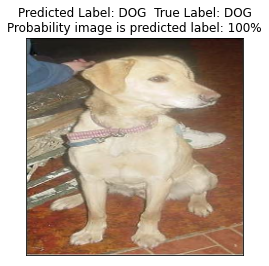

In [54]:
plot_image_prediction_true_value(trial_predictions, trial_valid_images, trial_valid_labels, 43)

In [ ]:
save_model(model, "1000-image-Inception-Adam-Model")

Saving model to: drive/My Drive/Cats and Dogs Project/models/20201024-17211603560102-1000-image-Inception-Adam-Model.h5...


'drive/My Drive/Cats and Dogs Project/models/20201024-17211603560102-1000-image-Inception-Adam-Model.h5'

# Training our model using full train and test data

In [ ]:
train_X, test_X, train_y, _ = create_train_test_datasets(
    X,
    boolean_labels
)

In [ ]:
train_data = create_data_batches(
    train_X,
    train_y
)

test_data = create_data_batches(
    test_X,
    test_data=True
)

Creating training data batches...
Creating test data batches...


In [ ]:
full_model = create_model()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1001)              6633209   
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2004      
Total params: 6,635,213
Trainable params: 2,004
Non-trainable params: 6,633,209
_________________________________________________________________


In [ ]:
full_model.fit(
    x=train_data,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/100
 12/625 [..............................] - ETA: 58s - loss: 0.5393 - accuracy: 0.7656

InvalidArgumentError: ignored

In [10]:
while True: pass #keeps codelab from disconnecting

KeyboardInterrupt: ignored